In [1]:
using CSV, DataFrames, Dates, Plots

## 1; Dados da pandemia de COVID-19 no Rio de Janeiro


- Os dados obtidos em [1] foram tratados no notebook  01_Tratamento_Dados_Covid_RJ.ipynb .


- Após carregar os dados, precisamos selecionar um ou mais períodos para modelar.

[1] https://www.data.rio/datasets/PCRJ::cep-dos-casos-confirmados-de-covid-19-no-munic%C3%ADpio-do-rio-de-janeiro-1/about

In [2]:
df = DataFrame(CSV.File("DadosMedia.csv"))

,DatasMedia,InfectadosMedia,RecuperadosMedia,ObitosMedia
,Date,Float64,Float64,Float64
1,2020-01-07,6.0,0.0,0.0
2,2020-01-08,6.71429,0.142857,0.0
3,2020-01-09,7.0,0.571429,0.0
4,2020-01-10,7.28571,1.0,0.0
5,2020-01-11,7.57143,1.42857,0.0
6,2020-01-12,7.57143,2.0,0.0
7,2020-01-13,7.14286,2.71429,0.0
8,2020-01-14,6.57143,3.42857,0.0
9,2020-01-15,6.14286,4.0,0.0


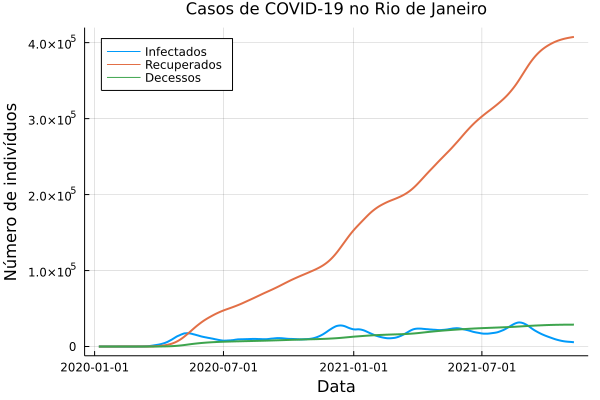

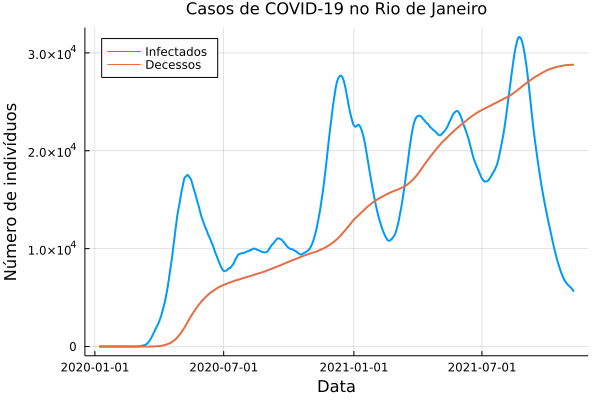

In [3]:
DatasTudo = df[:, "DatasMedia"]
InfTudo = df[:, "InfectadosMedia"]
RecTudo = df[:, "RecuperadosMedia"]
DecTudo = df[:, "ObitosMedia"]

pl = plot(DatasTudo, hcat(InfTudo, RecTudo, DecTudo), label = ["Infectados" "Recuperados" "Decessos"], lw = 2)
plot!(pl, title = "Casos de COVID-19 no Rio de Janeiro", titlefont = 11, gridalpha = 0.22,
    xlabel = "Data", ylabel = "Número de indivíduos", legend = :topleft)
display(pl)

pl = plot(DatasTudo, hcat(InfTudo, DecTudo), label = ["Infectados" "Decessos"], lw = 2)
plot!(pl, title = "Casos de COVID-19 no Rio de Janeiro", titlefont = 11, gridalpha = 0.22,
    xlabel = "Data", ylabel = "Número de indivíduos", legend = :topleft)
display(pl)

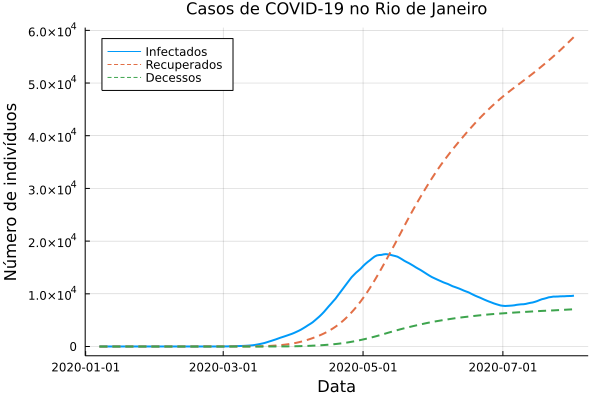

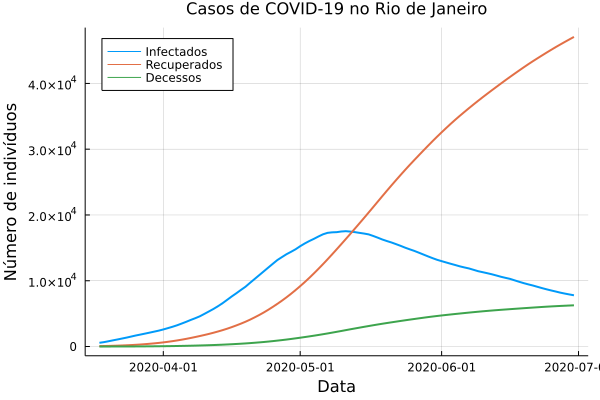

In [4]:
LimiteD = findall(data -> data == Date(2020, 08, 01), DatasTudo)[1]

pl = plot(DatasTudo[1:LimiteD], InfTudo[1:LimiteD], label = "Infectados", lw = 2)
plot!(pl, DatasTudo[1:LimiteD], RecTudo[1:LimiteD], label = "Recuperados", lw = 2, linestyle = :dash)
plot!(pl, DatasTudo[1:LimiteD], DecTudo[1:LimiteD], label = "Decessos", lw = 2, linestyle = :dash)
plot!(pl, title = "Casos de COVID-19 no Rio de Janeiro", titlefont = 11, gridalpha = 0.22,
    xlabel = "Data", ylabel = "Número de indivíduos", legend = :topleft)
display(pl)

LimiteE = findall(data -> data == Date(2020, 03, 18), DatasTudo)[1]
LimiteD = findall(data -> data == Date(2020, 06, 30), DatasTudo)[1]

pl = plot(DatasTudo[LimiteE:LimiteD], InfTudo[LimiteE:LimiteD], label = "Infectados", lw = 2)
plot!(pl, DatasTudo[LimiteE:LimiteD], RecTudo[LimiteE:LimiteD], label = "Recuperados", lw = 2)
plot!(pl, DatasTudo[LimiteE:LimiteD], DecTudo[LimiteE:LimiteD], label = "Decessos", lw = 2)
plot!(pl, title = "Casos de COVID-19 no Rio de Janeiro", titlefont = 11, gridalpha = 0.22,
    xlabel = "Data", ylabel = "Número de indivíduos", legend = :topleft)
display(pl)

In [5]:
DatasOnda = DatasTudo[LimiteE:LimiteD]
InfOnda = InfTudo[LimiteE:LimiteD]
RecOnda = RecTudo[LimiteE:LimiteD]
DecOnda = DecTudo[LimiteE:LimiteD]

nothing

## 2; Ajustando um modelo SEIAR

In [6]:
using DifferentialEquations, Optim, Random, Statistics
using Distributions: MvNormal
include("AuxMisc.jl")

- Modelo com parâmetros restritos:

\begin{align*}
    \begin{cases}
        \dot S &\hspace{-0.8em}= -\beta\frac{I+A}{N}S \\
        \dot E &\hspace{-0.8em}= \beta\frac{I+A}{N}S - \omega E \\
        \dot I &\hspace{-0.8em}= \omega\lambda E - (\gamma_R+\gamma_D)I \\
        \dot A &\hspace{-0.8em}= \omega\bar\lambda E - \rho A \\ 
        \dot R_I &\hspace{-0.8em}= \gamma_RI \\
        \dot R_A &\hspace{-0.8em}= \rho A \\
        \dot D &\hspace{-0.8em}= \gamma_D I
    \end{cases}
\end{align*}

- Modelo com parâmetros $\in \mathbb{R}$:

\begin{align*}
    \begin{cases}
        \dot S &\hspace{-0.8em}= -\hat\beta^2\frac{I+A}{N}S \\
        \dot E &\hspace{-0.8em}= \hat\beta^2\frac{I+A}{N}S - \hat\omega^2 E \\
        \dot I &\hspace{-0.8em}= \hat\omega^2\varphi\left(\hat\lambda\right) E - \left(\hat\gamma_R^2+\hat\gamma_D^2\right)I \\
        \dot A &\hspace{-0.8em}= \hat\omega^2\left(1-\varphi\left(\hat\lambda\right)\right) E - \hat\rho^2 A \\ 
        \dot R_I &\hspace{-0.8em}= \hat\gamma_R^2I \\
        \dot R_A &\hspace{-0.8em}= \hat\rho^2 A \\
        \dot D &\hspace{-0.8em}= \hat\gamma_D^2 I
    \end{cases}
\end{align*}

Onde $\varphi(x) \in [0,1]$ para todo $x \in \mathbb{R}$.

- Vamos utilizar o segundo modelo.


- Na prática, vamos chamar $\hat\beta$ de $\beta$, $\hat\omega$ de $\omega$, etc., para não carregar a notação.

In [7]:
function φ(x)
    return max(0, min(x, 1))
end

function dudtSEIAR!(du, u, p, t)
    S, E, I, A, Ri, Ra, O = u
    N = S + E + I + A + Ri + Ra
    β, ω, λ, γ_R, γ_D, ρ  = p
    
    E_nov = β^2 * (I+A) * S/N # novos expostos
    dS = - E_nov
    dE = E_nov - ω^2*E
    dI = ω^2*φ(λ)*E - (γ_R^2+γ_D^2)*I
    dA = ω^2*(1-φ(λ))*E - ρ^2*A
    dRi = γ_R^2*I
    dRa = ρ^2*A
    dO = γ_D^2*I
    
    du[1] = dS; du[2] = dE; du[3] = dI; du[4] = dA; du[5] = dRi; du[6] = dRa; du[7] = dO
end

dudtSEIAR! (generic function with 1 method)

### 2.1; Ajuste para os dados do período completo

- Primeiramente, tentaremos ajustar os parâmetros para os dados de todo o período em análise, na expectativa deduzir algumas propriedades do modelo e dos dados.


- Realizaremos o ajuste dos parâmetros $\beta$, $\omega$, $\lambda$, $\gamma_R$, $\gamma_D$ e $\rho$ e da condição inicial $S_0$ minimizando $SS(\boldsymbol{r})$ nas variáveis $I$, $R_I$ e $D$:

In [8]:
UltimoDia = convert(Float64,length(DatasOnda))
TimeSpan = (1.,UltimoDia)
Dias = [1:UltimoDia...]
Diass = 1.:0.2:UltimoDia

#PopulacaoTotal = 6748000. # População total da cidade do Rio de Janeiro
ExpostosIniciais = 2_000. # ???
AssintomaticosIniciais = 1_000. # ???
RecuperadosAssintomaticosIniciais = 100. # ???

u₀Dados = [ExpostosIniciais, InfOnda[1], AssintomaticosIniciais, RecOnda[1],
    RecuperadosAssintomaticosIniciais, DecOnda[1]]

#ParametrosIniciais = [2_500, 1., 1., 0.1, 0.05, 0.05, 1.]
ParametrosIniciais = [6_000_000, 1., 1., 0.1, 0.05, 0.05, 1.]

DadosOnda = hcat(InfOnda,RecOnda,DecOnda)'

#ModeloInfRecDec(Parametros) = solve(ODEProblem(dudtSEIAR!, [Parametros[1]^2; u₀Dados], TimeSpan, Parametros[2:end]), 
#    saveat = Dias)[[3, 5, 7], :]
ModeloInfRecDec(Parametros) = solve(ODEProblem(dudtSEIAR!, [Parametros[1]; u₀Dados], TimeSpan, Parametros[2:end]), 
    saveat = Dias)[[3, 5, 7], :]


Custo(Parametros) = sum(abs2, DadosOnda .- ModeloInfRecDec(Parametros))

Resultado = optimize(Custo, ParametrosIniciais, iterations = 10^4)

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     9.178600e+07

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    53790


Parâmetros ajustados:
    β = 1.399
    ω = 1.43
    λ = 0.009
    γ_R = 0.211
    γ_D = -0.079
    ρ = 1.397

Parâmetros do modelo restrito:
    β = 1.958
    ω = 2.044
    λ = 0.009
    γ_R = 0.044
    γ_D = 0.006
    ρ = 1.952

Suscetíveis iniciais ajustados = 1.43e+7


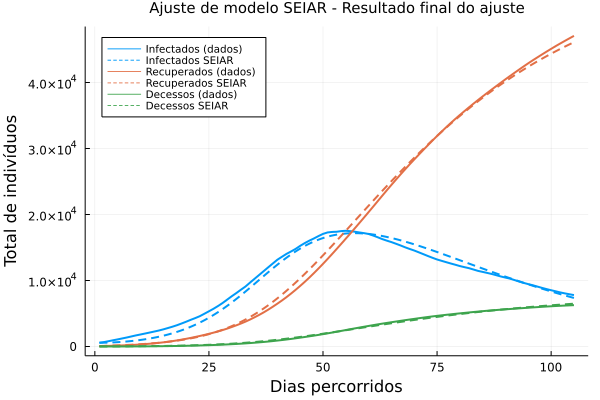

In [9]:
ParametrosFinais = Optim.minimizer(Resultado)
S₀, β, ω, λ, γ_R, γ_D, ρ = ParametrosFinais

println("Parâmetros ajustados:
    β = $(round(β, digits=3))
    ω = $(round(ω, digits=3))
    λ = $(round(λ, digits=3))
    γ_R = $(round(γ_R, digits=3))
    γ_D = $(round(γ_D, digits=3))
    ρ = $(round(ρ, digits=3))")

println("\nParâmetros do modelo restrito:
    β = $(round(β^2, digits=3))
    ω = $(round(ω^2, digits=3))
    λ = $(round(φ(λ), digits=3))
    γ_R = $(round(γ_R^2, digits=3))
    γ_D = $(round(γ_D^2, digits=3))
    ρ = $(round(ρ^2, digits=3))")

s0 = SciRound(S₀)

println("\nSuscetíveis iniciais ajustados = ", s0)

Modelo = solve(ODEProblem(dudtSEIAR!, [S₀; u₀Dados], TimeSpan, ParametrosFinais[2:end]), saveat = Diass)

InfModelo = Modelo[3,:]
RecModelo = Modelo[5,:]
DecModelo = Modelo[7,:]

plot(Dias, InfOnda, label = "Infectados (dados)", lw = 2, color = 1)
plot!(Diass,InfModelo, label = "Infectados SEIAR", lw = 2, color = 1, linestyle = :dash)

plot!(Dias, RecOnda, label = "Recuperados (dados)", lw = 2, color = 2)
plot!(Diass,RecModelo, label = "Recuperados SEIAR", lw = 2, color = 2, linestyle = :dash)

plot!(Dias, DecOnda, label = "Decessos (dados)", lw = 2, color = 3)
plot!(Diass, DecModelo, label = "Decessos SEIAR", lw = 2, color = 3, linestyle = :dash)

plot!(title = "Ajuste de modelo SEIAR - Resultado final do ajuste", titlefont = 10,
    xlabel = "Dias percorridos", ylabel = "Total de indivíduos", legend = :topleft, legendfont = 7)

### 2.2; Ajuste para dados dos $N$ primeiros dias


- Vamos ajustar os parâmetros do modelo utilizando somente os dados dos $N$ primeiros dias para testar sua capacidade de previsão.

In [10]:
using Random, DiffEqFlux

Random.seed!(1234)

function initializeNN(NN, inputVectorSize, varFactor; func = X -> 0., numDataPoints = 200)
    Xs = rand(inputVectorSize, numDataPoints) .* varFactor
    
    data_func = [func(X) for X in eachcol(Xs)]
    
    function cost(θ)
        pred = [NN(X, θ)[1] for X in eachcol(Xs)]
        return sum(abs2, data_func .- pred), pred
    end

    costs = []

    function callBack(θ, cost, pred)
        push!(costs, cost)
        if length(costs) % 50 == 0
            println("Iteracao : ", length(costs), " , Erro : ", SciRound(cost))
        end
        false
    end
    
    resultBFGS = DiffEqFlux.sciml_train(cost, initial_params(NN), cb = callBack, BFGS(initial_stepnorm = 0.01), maxiters = 1_000, allow_f_increases = true);
    return resultBFGS.minimizer
end

NN2x1 = FastChain(FastDense(2,16,tanh), FastDense(16,16,tanh), FastDense(16,1), (x, θ) -> x.^2)

(::FastChain{Tuple{FastDense{typeof(tanh), DiffEqFlux.var"#initial_params#82"{Vector{Float32}}}, FastDense{typeof(tanh), DiffEqFlux.var"#initial_params#82"{Vector{Float32}}}, FastDense{typeof(identity), DiffEqFlux.var"#initial_params#82"{Vector{Float32}}}, var"#16#17"}}) (generic function with 1 method)

In [18]:
function AjusteNPrimeirosDias(N; InfOnda = InfOnda, RecOnda = RecOnda, DecOnda = DecOnda, u₀Dados = u₀Dados,
        ParametrosIniciais = ParametrosIniciais, NumIter = 10^4, MostrarLegenda = true, yLim = 30000)
    
    UltimoDia = convert(Float64,length(DatasOnda))
    TimeSpan = (1.,UltimoDia)
    Dias = [1:UltimoDia...]
    Diass = 1.:0.2:UltimoDia

    DiasTreino = [1:N...]
    DadosTreino = hcat(InfOnda[1:N], RecOnda[1:N], DecOnda[1:N])'
    
    ModeloTreino(Parametros) = solve(ODEProblem(dudtSEIAR!, [Parametros[1]; u₀Dados], TimeSpan, Parametros[2:end]), 
        saveat = DiasTreino)[[3, 5, 7], :]
    
    Custo(Parametros) = sum(abs2, DadosTreino .- ModeloTreino(Parametros))
    Resultado = optimize(Custo, ParametrosIniciais, iterations = NumIter)
    
    ParametrosFinais = Optim.minimizer(Resultado)
    S₀, β, ω, λ, γ_R, γ_D, ρ = ParametrosFinais
    
    Modelo = solve(ODEProblem(dudtSEIAR!, [S₀; u₀Dados], TimeSpan, ParametrosFinais[2:end]), saveat = Diass)

    InfModelo = Modelo[3,:]
    RecModelo = Modelo[5,:]
    DecModelo = Modelo[7,:]

    pl = plot(Dias, InfOnda, label = "Infectados - dados", lw = 2, color = 1)
    plot!(pl, Diass, InfModelo, label = "Infectados - SEIAR", lw = 2, linestyle = :dash, color = 1)

    plot!(pl,Dias, RecOnda, label = "Recuperados - dados", lw = 2, color = 2)
    plot!(pl, Diass, RecModelo, label = "Recuperados - SEIAR", lw = 2, linestyle = :dash, color = 2)

    plot!(pl,Dias, DecOnda, label = "Decessos - dados", lw = 2, color = 3)
    plot!(pl, Diass, DecModelo, label = "Decessos - SEIAR", lw = 2, linestyle = :dash, color = 3)
    
    plot!(pl, [N], seriestype = "vline", label = "Último dia do ajuste", color = "red")
    
    plot!(pl, title = "Ajuste de modelo SEIAR com $N dias de treino", titlefont = 11, xlabel = "Dias percorridos",
        ylabel = "Total de indivíduos", legend = MostrarLegenda, legendfont = 7, ylim = (-500, yLim))
    
    ParametrosFinais, pl
end

AjusteNPrimeirosDias (generic function with 1 method)

In [19]:
#AjusteNPrimeirosDias(20, MostrarLegenda = :topleft)

In [20]:
#AjusteNPrimeirosDias(40, MostrarLegenda = false)

In [21]:
#AjusteNPrimeirosDias(55, MostrarLegenda = false)

In [22]:
θ, pl = AjusteNPrimeirosDias(40, MostrarLegenda = false)

([581965.9998063286, 1.0661097553366476, 11.9682503244976, 0.10413364998637381, 0.17956992090021195, 0.06453599447274413, 5.413295935670954], Plot{Plots.GRBackend() n=7})

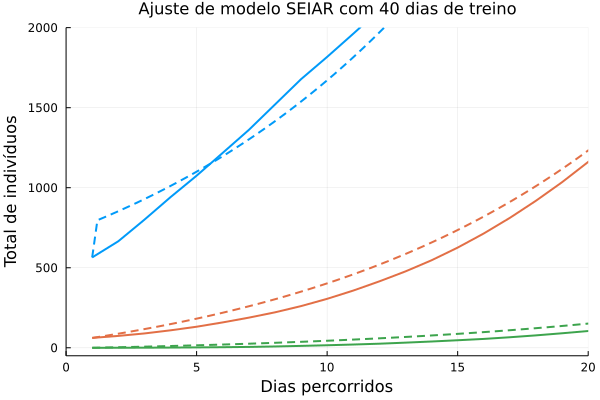

In [23]:
plot!(pl, xlim = (0, 20), ylim = (-50, 2_000))

In [24]:
θ

7-element Vector{Float64}:
 581965.9998063286
      1.0661097553366476
     11.9682503244976
      0.10413364998637381
      0.17956992090021195
      0.06453599447274413
      5.413295935670954